# Todo


* Build PCA from much larger set of sky observations
* work off real spectra (not sky_spectrum)



# Notes
* all experiments are currently in pca_sky1.ipynb and pca_sky3.ipynb 
* this notebook is meant for production

In [1]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Next two lines force automatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from astropy.io import fits
from astropy.stats import biweight_location
from sklearn.decomposition import PCA
import pickle
import os
import glob
from matplotlib import pyplot as plt
% matplotlib inline

from collections import OrderedDict
import spectrum

In [3]:
def load_skys(ff,which="sky_spectrum", normalize=False):
    skys = OrderedDict()
    shotids = OrderedDict()
    N = len(ff)
    sff = []
    for i,f in enumerate(ff):
        if i % 100 == 0:
            print("loading {} out of {}.".format(i,N))
        shotid = f.split("/")[2]
        exp = f.split("/")[3]
        try:
            ww,rb = pickle.load( open(f,'rb'), encoding='iso-8859-1' )
            skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"] 
            shotids[(shotid,exp)] = f
        except:
            print("Error loading {}.".format(f))
            pass
        
        if normalize:
            # NEW try to normalize by mean
            skys[(shotid,exp)][np.isnan(skys[(shotid,exp)])] = 0.
            skys[(shotid,exp)] = (skys[(shotid,exp)].T /np.mean( skys[(shotid,exp)], axis=1 )).T
    print("start wl = ", ww[0], "A", "end wl = ", ww[-1], "A")
    return ww, skys, sff

In [4]:
def build_XA(IFU, ww, skys, wstart, wend):
    # Select referece source
    # here we will use as A  the beiweight location (~ mean) from the entire IFU 
    XA = []
    for k in skys[(IFU,"LU")]:
        amps = []
        if k in skys[(IFU,"LU")]:
            amps.append( skys[(IFU,"LU")][k] )
        if k in skys[(IFU,"LL")]:
            amps.append( skys[(IFU,"LL")][k] )
        if k in skys[(IFU,"RU")]:
            amps.append( skys[(IFU,"RU")][k] )
        if k in skys[(IFU,"RL")]:
            amps.append( skys[(IFU,"RL")][k] )
        stack = np.vstack(amps)
        bloc = biweight_location( stack, axis=0) 
        XA.append(bloc)

    XA = np.array(XA)

    # hack to homogenize lengths, the rebinning does make sure
    # that the wavelength grid always stars at the same wavelength
    # but not necessarey, end at the same ( ther may be a few pixel more or less)
    #N = np.min([XA.shape[1], XB.shape[2], ww.shape[0]])
    N = np.min([XA.shape[1], ww.shape[0]])
    ww = ww[:N]
    XA = XA[:,:N]

    # can't have nans
    XA[np.isnan(XA)] = 0.

    ii = (ww >= wstart) * (ww <= wend)
    wwcut = ww[ii]
    XAcut = XA[:,ii]

    return wwcut, XAcut

In [5]:
def build_XB(IFU, amp, ww, skys, wstart, wend):
    B = (IFU, amp) # here we select, which IFU and amp we build the 
                     # PCA sky for
        
    # first build big array that holds all skys in B
    XB = np.array( [skys[B][k] for k in skys[B] ] )

    #N = XA.shape[1]
    ii = (ww >= wstart) * (ww <= wend)
    
    ## we homogenize the length
    #XB = XB[:,:,:N]
    # set nans to zero
    XB[np.isnan(XB)] = 0.
    # and select a spectral subrange as set above
    XBcut = XB[:,:,ii]

    return wwcut, XBcut


In [6]:
IFU="022"
dir_rebin="pca_test/rebin"
# selct wavelength subrange
wstart = 3495.
wend = 5493.

# how many PCA components do we want to maintain?
n_components = 50

amps = ["LL", "LU", "RL", "RU"]

# Source shotlist for sky PCA component computation
s = """
20180104v007 20180207v007 20180213v008 #20180221v008 20180309v002 20180316v012
20180104v008 20180207v008 20180213v011 #20180221v009 20180309v003 20180316v013
20180106v004 20180208v010 20180213v012 #20180221v010 20180309v004 20180316v015
20180106v005 20180208v011 20180213v013 #20180221v011 20180309v007 20180316v016
20180107v002 20180208v012 20180213v015 #20180221v012 20180309v012 20180317v007
20180107v003 20180208v013 20180213v016 #20180221v013 20180310v002 20180317v008
20180110v008 20180208v014 20180213v017 #20180221v014 20180310v006 20180317v009
20180110v021 20180209v008 20180213v020 20180222v011 20180310v007 20180317v010
20180112v007 20180209v009 20180214v008 20180222v012 20180311v007 20180317v011
20180112v009 20180209v010 20180214v009 20180222v013 20180311v008 20180317v012
20180112v010 20180209v011 20180214v010 20180222v014 20180311v009 20180319v013
20180112v011 20180209v012 20180214v011 20180222v015 20180311v010 20180319v015
20180112v012 20180209v013 20180214v012 20180222v016 20180312v006 20180320v008
20180113v006 20180209v014 20180215v004 20180222v017 20180312v007 20180320v009
20180113v010 20180210v005 20180215v005 20180222v018 20180312v008 20180320v013
20180113v011 20180210v006 20180215v006 20180222v019 20180312v009 20180320v014
20180113v012 20180210v007 20180215v007 20180223v010 20180312v010 20180320v015
20180113v013 20180210v008 20180215v008 20180223v011 20180312v014 20180321v009
20180113v014 20180210v009 20180215v009 20180223v012 20180313v007 20180321v010
20180113v015 20180210v010 20180215v010 20180223v017 20180313v008 20180321v011
20180114v012 20180210v011 20180215v011 20180224v003 20180313v009 20180321v012
20180114v013 20180210v012 20180215v012 20180224v004 20180313v010 20180321v013
20180114v014 20180210v013 20180215v013 20180224v005 20180313v011 20180321v014
20180115v010 20180210v014 20180215v014 20180224v006 20180313v012 20180321v015
20180115v011 20180211v013 20180215v015 20180224v007 20180313v013 20180321v020
20180115v012 20180211v017 20180216v009 20180224v008 20180313v014 20180321v021
20180119v016 20180211v018 20180216v010 20180224v009 20180313v015 20180321v022
20180120v008 20180212v008 20180216v011 20180224v010 20180313v016 20180321v023
20180120v009 20180212v009 20180216v012 20180307v002 20180313v017 20180321v024
20180123v008 20180212v010 20180216v013 20180307v003 20180316v007 20180321v025
20180123v009 20180212v011 20180220v013 20180307v004 20180316v008 20180321v026
20180123v010 20180212v012 20180220v014 20180307v006 20180316v009
20180124v010 20180212v013 20180220v015 20180308v002 20180316v010
20180124v011 20180212v014 #20180221v006 20180309v001 20180316v011
"""
s = """
20180110v021
20180113v013
20180114v013
20180120v008
20180123v009
20180124v010
20180209v009
20180210v006
"""
s = """
20180110v008 20180110v021 20180113v006 20180113v010 20180113v011 20180113v012
20180113v013 20180113v014 20180113v015 20180114v012 20180114v013 20180114v014
20180120v008 20180120v009 20180123v008 20180123v009 20180123v010 20180124v010
20180124v011 20180209v008 20180209v009 20180209v010 20180209v011 20180209v012
20180209v013 20180209v014 #20180210v005 20180210v006 #20180210v007 #20180210v008
#20180210v009 #20180210v010 #20180210v011 #20180210v012 20180210v013 #20180210v014
"""
s = """ 
20180110v021 20180110v008
20180113v013
20180114v013
20180120v008
20180123v009
20180124v010
20180209v009
20180210v006
"""
shotlist_PCA = s.split()


# Target shot list for the PCA based sky reconstruction
# Here early 2018 COSMOS repeat
s = """
20180110v021 20180110v008
20180113v013
20180114v013
20180120v008
20180123v009
20180124v010
20180209v009
20180210v006
"""
shotlist_skyrecon = s.split()


# First part: Compute PCA components for A & B based on a large number of skys

In [7]:
# load rebinned data
ff = OrderedDict()
for amp in amps:
    ff[amp] = []
    for shot in shotlist_PCA:
        if shot.startswith("#"):
            continue
        cmd = "ls {}/{}/exp0?/multi_???_{}_???_{}_rebin.pickle".format(dir_rebin,shot, IFU, amp)
        tmp = !$cmd
        ff[amp] += tmp
 
skys = OrderedDict()
for amp in amps:
    ww,skys[(IFU,amp)],sff = load_skys(ff[amp],which="sky_spectrum")
    
shotids = [k for k in skys[(IFU,"LL")] ]

# build data matrix A
wwcut, XAcut = build_XA(IFU, ww, skys, wstart, wend)

# normilze (usually done by scikit.learn's PCA method also, but useful for plotting etc.)
MA = np.mean(XAcut,axis=0)
XAmean = XAcut - MA

loading 0 out of 27.
start wl =  3494.74 A end wl =  5498.4523582 A
loading 0 out of 27.
start wl =  3494.74 A end wl =  5496.4665184 A
loading 0 out of 27.
start wl =  3494.74 A end wl =  5492.494838799999 A
loading 0 out of 27.


/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


start wl =  3494.74 A end wl =  5498.4523582 A


/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 5 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/astropy/stats/biweight.py:112: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(u) >= 1)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 4 results
  r = func(a, **kwargs)


In [8]:
XAcut.shape

(27, 1006)

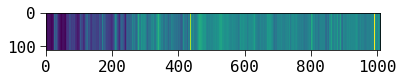

In [9]:
plt.imshow( skys[('022', 'LL')][('20180113v013', 'exp01')] )

[3770.29638151 1001.02077793  297.33296769  215.04665832  176.23802223
   83.61087224   65.22662084   52.86444688   38.53361965   28.22680572
   26.56973335   24.20091891   22.88206861   22.35257936   21.53566029
   21.04849716   20.73431645   20.36016481   19.83091888   19.26222408]


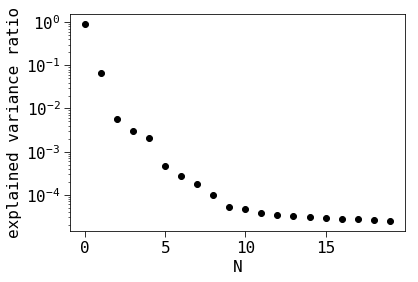

In [10]:
# PCA computation for A
n_components = 20
pcaA = PCA(n_components=n_components)
pcaA.fit(XAmean)
plt.plot(pcaA.explained_variance_ratio_, 'o')  
plt.xlabel("N")
plt.ylabel("explained variance ratio")
plt.yscale('log')
print(pcaA.singular_values_) 

In [11]:
# project pca componets onto
# mean shifted input spectra
ccA = np.inner(XAmean, pcaA.components_)

# reconstruct pca comonents through linear combination
rcA = np.matmul( XAmean.T, ccA).T

# they wont be normalized yet
for i,cA in enumerate(rcA):
    rcA[i] = rcA[i]/np.linalg.norm(rcA[i])

In [12]:
# make sure the result is the same
if not (np.abs( rcA - pcaA.components_) < 1e-6).all():
    print("ERROR: Recontructed PCA components are not (almost) identical to the original ones.")
else:
    print("Reconstructed PCAs look good.")

Reconstructed PCAs look good.


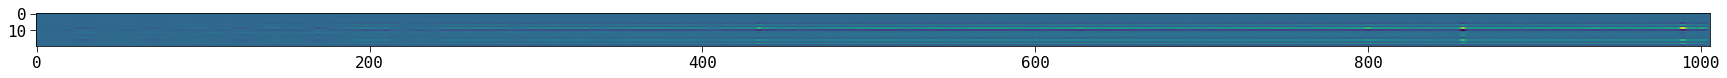

In [13]:
f=plt.figure(figsize=[30,5])
plt.imshow( rcA - pcaA.components_ )

In [14]:
# save pca components of A
pca_comp_fname = "{}/pca_comp_A_{}.pickle".format(dir_rebin, IFU)
pickle.dump(  (MA, pcaA.components_) , open(pca_comp_fname,'wb') , protocol=2   )
#pickle.dump(  (MA, rcA) , open(pca_comp_fname,'wb') , protocol=2   )
print("Wrote {}".format(pca_comp_fname))

Wrote pca_test/rebin/pca_comp_A_022.pickle


In [15]:
for amp in amps:
    wwcut, XBcut = build_XB(IFU, amp, ww, skys, wstart, wend)
    # now we subtract the mean of each column!, this is probably unnecassary as
    # the scikit learn PCA already does this, but it helps the plotting and so forth
    MB = np.mean(XBcut,axis=0)
    XBmean = XBcut - MB
    
    ### reconstruct pca components of all B fibers through linear combination of spectra from B ###
    rcB = OrderedDict() # will hald for all fibers (in the current amp) all the pseudo PCA components
    for fiber in range(XBmean.shape[1]):
        # BUT using projection from A
        rcB[fiber] = np.matmul( XBmean[:,fiber,:].T, ccA).T
        # they wont be normalized yet
        for j,cB in enumerate(rcB[fiber]):
            rcB[fiber][j] = rcB[fiber][j]/np.linalg.norm(rcB[fiber][j])
            
    pca_comp_fname = "{}/pca_comp_B_{}_{}.pickle".format(dir_rebin,IFU,amp)
    pickle.dump(  (MB,rcB) , open(pca_comp_fname,'wb') , protocol=2   )
    print("Wrote {}".format(pca_comp_fname))

Wrote pca_test/rebin/pca_comp_B_022_LL.pickle
Wrote pca_test/rebin/pca_comp_B_022_LU.pickle
Wrote pca_test/rebin/pca_comp_B_022_RL.pickle
Wrote pca_test/rebin/pca_comp_B_022_RU.pickle


In [16]:
# compute projection of input spectra onto PCA basis
#tA = pcaA.transform(XAmean)
tA = np.matmul( XAmean, rcA.T)

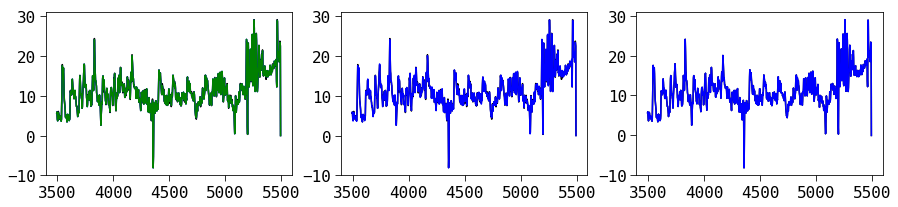

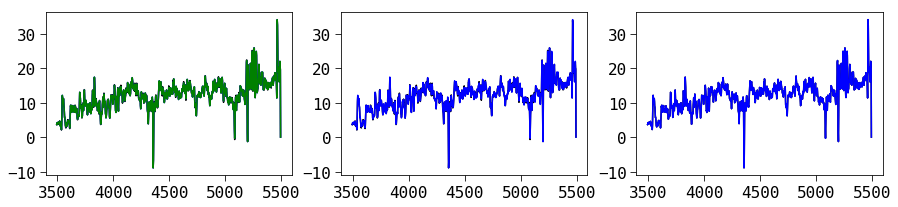

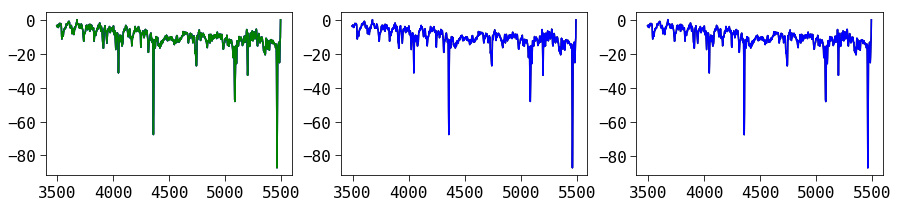

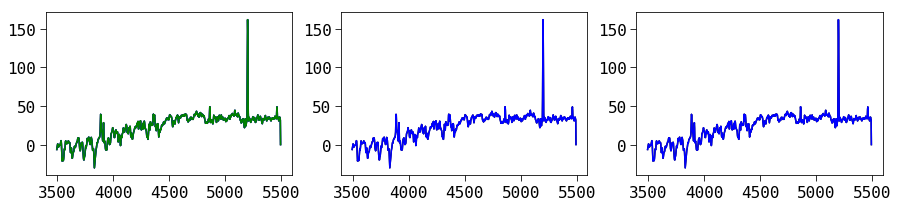

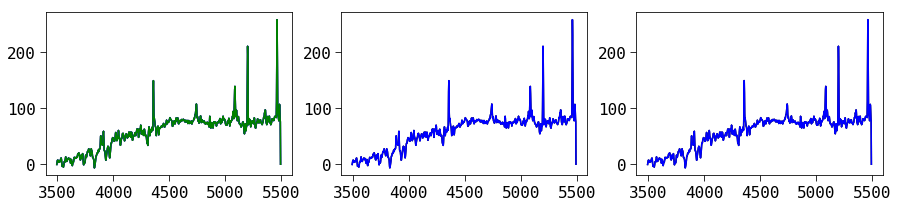

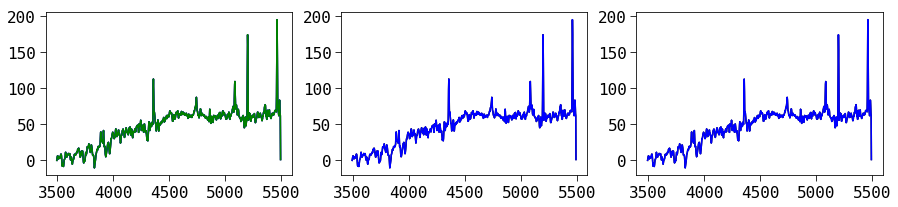

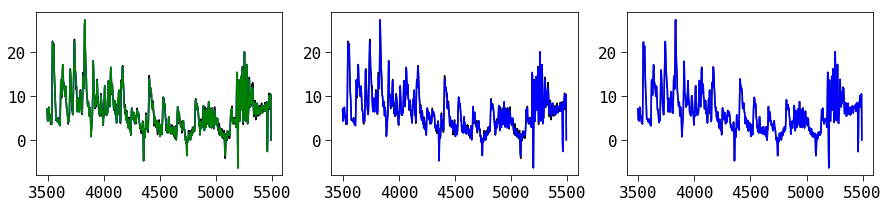

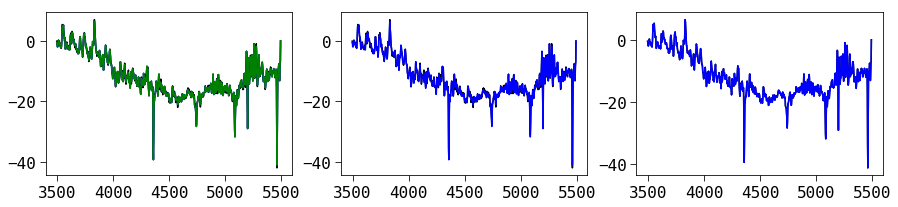

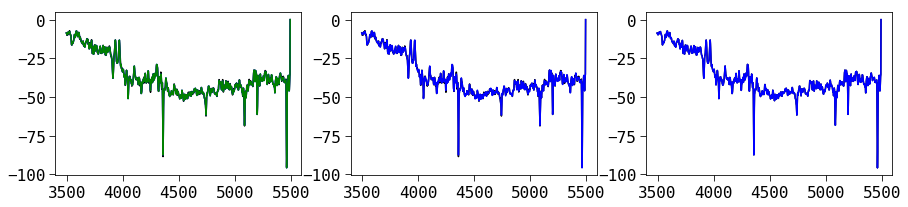

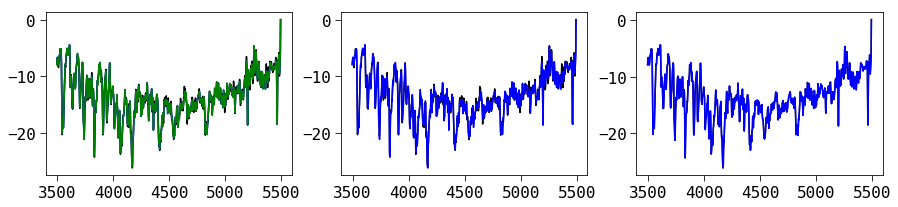

In [17]:
if True:
    # make sure we can reconstuct the spectra from the
    # actual principal components but also from the reconstructed ones
    for i in range(10):
        f = plt.figure(figsize=[15,3])
        plt.subplot(131)
        plt.plot(wwcut, XAmean[i] )
        plt.plot(wwcut,  np.inner(tA, pcaA.components_.T)[i] )
        plt.plot(wwcut,  pcaA.inverse_transform(tA)[i] )


        plt.subplot(132)
        plt.plot(wwcut,  XAmean[i] )
        plt.plot(wwcut,  np.inner(tA, rcA.T)[i] )


        plt.subplot(133)
        plt.plot(wwcut,  np.inner(tA, pcaA.components_.T)[i] )
        plt.plot(wwcut,  np.inner(tA, rcA.T)[i] )


# Now apply this to B

In [18]:
# load pca components of A
pca_comp_fname = "pca_test/rebin/pca_comp_A_{}.pickle".format(IFU)
MA,rcA = pickle.load( open(pca_comp_fname,'rb'), encoding='iso-8859-1' )

# load rebinned sky data
ff = OrderedDict()
for amp in amps:
    ff[amp] = []
    for shot in shotlist_skyrecon:
        if shot.startswith("#"):
            continue
        cmd = "ls pca_test/rebin/{}/exp0?/multi_???_{}_???_{}_rebin.pickle".format(shot, IFU, amp)
        tmp = !$cmd
        ff[amp] += tmp
 
skys = OrderedDict()
for amp in amps:
    ww,skys[(IFU,amp)],sff = load_skys(ff[amp], which="sky_spectrum")
    
shotids = [k for k in skys[(IFU,"LL")] ]

# build data matrix A
wwcut, XAcut = build_XA(IFU, ww, skys, wstart, wend)

# normalize 
# but normalize with respect to 
# the mean that we used fot the PCA component calculation
#MA = np.mean(XAcut,axis=0)
XAmean = XAcut - MA

# compute projection of input spectra onto PCA basis
tA = np.matmul( XAmean, rcA.T)


loading 0 out of 27.
start wl =  3494.74 A end wl =  5498.4523582 A
loading 0 out of 27.
start wl =  3494.74 A end wl =  5496.4665184 A
loading 0 out of 27.
start wl =  3494.74 A end wl =  5492.494838799999 A
loading 0 out of 27.
start wl =  3494.74 A end wl =  5498.4523582 A


/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 5 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/astropy/stats/biweight.py:112: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(u) >= 1)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 4 results
  r = func(a, **kwargs)


ValueError: operands could not be broadcast together with shapes (27,1006) (986,) 

In [ ]:

#for amp in ["LU", "LL", "RU", "RL"]:
for amp in ["LL"]:
    B = (IFU, amp) 

    # load pca components of B
    pca_comp_fname = "pca_test/rebin/pca_comp_B_{}_{}.pickle".format(IFU,amp)
    MB, rcB = pickle.load( open(pca_comp_fname,'rb'), encoding='iso-8859-1' )

    wwcut, XBcut = build_XB(IFU, amp, ww, skys, wstart, wend)
    # now we subtract the mean of each column!, this is probably unnecassary as
    # the scikit learn PCA already does this, but it helps the plotting and so forth
    #MB = np.mean(XBcut,axis=0)
    XBmean = XBcut - MB
    

    ### reconstruct pca components of all B fibers through linear combination of spectra from B ###
    rcB = OrderedDict() # will hald for all fibers (in the current amp) all the pseudo PCA components
    for fiber in range(XBmean.shape[1]):
        # BUT using projection from A
        rcB[fiber] = np.matmul( XBmean[:,fiber,:].T, tA).T
        # they wont be normalized yet
        for j,cB in enumerate(rcB[fiber]):
            rcB[fiber][j] = rcB[fiber][j]/np.linalg.norm(rcB[fiber][j])
                
    # Now reconstruct sky for all exposures and fibers
    B_recon_sky = np.zeros_like(XBmean)
    for i in range(XBmean.shape[0]): # loop over exposures
        for fiber in range(XBmean.shape[1]):  # loop over fibers
            # now compute sky from pseudo PCA components of B
            # according to weights of A
            B_recon_sky[i,fiber,:] = np.inner(tA, rcB[fiber].T)[i] + MB[fiber,:]
            

    # Quality control
    # plot for 10 randomly picked exposures
    # recontrcuted sky and residuals of one (or a few) fiber(s)
    np.random.seed(42)
    qa_exposures = np.array( np.random.uniform(size=10) * XBmean.shape[0], dtype=int)
    qa_fibers = [75]
    
    for i in qa_exposures: # loop over exposures
        for fiber in qa_fibers:  # loop over fibers
            f = plt.figure(figsize=[15,3])
            ax = plt.subplot(121)
            
            y  = XAmean[i] + MA
            ry = np.inner(tA, pcaA.components_.T)[i] + MA
            res = ry-y
            plt.plot(wwcut,  y )
            plt.plot(wwcut,   ry )
            plt.twinx()
            plt.plot(wwcut,   res, 'g.'  )
            plt.ylim([-2.,10.])
            plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
            plt.text(0.05,0.95,"A\n{}\n{}\n{}".format(shotids[i][0], shotids[i][1], B[0],  fiber ), transform = ax.transAxes, ha='left',va='top')
            
            ax = plt.subplot(122, sharex=ax)
            y  = XBmean[i,fiber,:] + MB[fiber,:] # original sky in B
            ry = B_recon_sky[i,fiber,:]          # reconstructed sky in B
            res = ry-y

            plt.plot(wwcut,   y )
            plt.plot(wwcut,   ry )
            plt.twinx()

            plt.plot(wwcut,   res, 'g.' )
            plt.ylim([-2,10.])
            plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
            plt.text(0.05,0.95,"B\n{}\n{}\n{}\n{}".format(shotids[i][0], shotids[i][1], B[0],  B[1], fiber ), transform = ax.transAxes, ha='left',va='top')
                     


    def save_sky(IFU, amp , k, wwcut, pca_sky):
        pattern="pca_test/rebin/{}/{}/multi_???_{}_???_{}_rebin.pickle"
        shotid, exp = k

        _pattern = pattern.format(shotid, exp, IFU, amp)
        ff = glob.glob(_pattern)
        if not len(ff) == 1:
            print("ERROR: Did not find files like {}".format(_pattern))
            return
        fname = ff[0]

        h,t = os.path.split(fname)
        pca_fname = os.path.join(h,"pca_" + t)

        ww,rb = pickle.load( open(fname,'rb'), encoding='iso-8859-1' )
        
        N = np.min([ww.shape[0], rb['sky_subtracted'].shape[1], rb["fiber_to_fiber"].shape[1], rb["sky_spectrum"].shape[1]])
        rb["fiber_to_fiber"] = rb["fiber_to_fiber"][:,:N]
        rb["sky_subtracted"] = rb["sky_subtracted"][:,:N]
        ww = ww[:N]
        rb["sky_spectrum"] = rb["sky_spectrum"][:,:N]
        rb["pca_sky_spectrum"] = rb["sky_spectrum"].copy()
        ii = (ww >= wwcut[0]) * (ww <= wwcut[-1])
        rb["pca_sky_spectrum"][:,ii] = pca_sky * rb["fiber_to_fiber"][:,ii]
        
        
        rb['sky_subtracted'] = rb['sky_subtracted'] + rb['sky_spectrum'] - rb['pca_sky_spectrum']

        pickle.dump(  ( ww,rb), open(pca_fname,'wb') , protocol=2   )
        print("Wrote ", pca_fname)
        

        
    for i,k in enumerate(shotids):

        save_sky(IFU, amp , k, wwcut, B_recon_sky[i])



    #save_skys(B, pca_sky, pattern)

In [ ]:
ccA.shape
#B_recon_sky[i,fiber,:]
#np.inner(tA, rcB[fiber].T)[i] 

In [ ]:
np.inner(tA, rcB[fiber].T).shape

In [ ]:
%pdb

In [ ]:
!ls pca_test/rebin/20180110v021/exp03/pca_multi_316_032_052_LU_rebin.pickle

In [ ]:
f = plt.figure(figsize=[15,15])
ff = glob.glob("pca_test/rebin/20180110v021/exp03/pca_multi_???_{}_???_LL_rebin.pickle".format(IFU))
ww,rb = pickle.load(open(ff[0], 'rb'))

f = plt.figure()
plt.subplot(311)
plt.imshow( rb['sky_spectrum'] , vmax=200.)
plt.subplot(312)
plt.imshow( rb['pca_sky_spectrum'] , vmax=200.)
plt.subplot(313)
plt.imshow( rb['sky_spectrum'] - rb['pca_sky_spectrum'], vmin=-2., vmax=2. )

res = rb['sky_spectrum'] - rb['pca_sky_spectrum']
np.std(res.flatten())

In [ ]:
for k in  shotids:
    for amp in ["LU", "LL", "RU", "RL"]:
        shotid, exp = k
        pattern = "pca_test/rebin/{}/{}/pca_multi_???_{}_???_{}_rebin.pickle".format(shotid, exp, IFU, amp)
        ff = glob.glob(pattern)
        print(pattern)
        ww,rb = pickle.load(open(ff[0], 'rb'))

        f = plt.figure(figsize=[15,15])
        plt.subplot(511)
        plt.imshow( rb['sky_spectrum'] , vmax=200.)
        plt.subplot(512)
        plt.imshow( rb['pca_sky_spectrum'] , vmax=200.)
        plt.subplot(513)
        plt.imshow( rb['sky_spectrum'] - rb['pca_sky_spectrum'], vmin=-2., vmax=2. )
        
        plt.subplot(514)
        plt.imshow( rb['sky_subtracted'], vmin=-50., vmax=50. ) 
        plt.subplot(515)
        plt.imshow( rb['sky_subtracted'] + rb['sky_spectrum'] - rb['pca_sky_spectrum'] , vmin=-50., vmax=50. )
        break
    break